In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# My implemention of Bayes Classifier

In [6]:
# All digits
DIGITS = list(range(10))
# values of pixels
VALUES = [0, 1]
# the index of label
LABEL_COLUMN = 0
# the columns of features
FEATURE_COLUMNS = list(range(1, 785))


class BayesModel:
    def __init__(self, data, k=1):
        # Laplace smoothing parameter k
        self.k = k

        self.data = data
        # calculate prior
        self.prior = self.calculate_prior()

        # calculate likelihoods
        self.likelihoods = dict()
        self.fit()

    def calculate_prior(self):
        counter = self.data[LABEL_COLUMN].value_counts()
        return counter / self.data.shape[0]

    def __str__(self):
        return "Bayes model, using k={}".format(self.k)

    __repr__ = __str__

    def fit(self):
        """Fit the model"""
        print("Fitting model ...")
        for digit in DIGITS:
            df = self.data[self.data[LABEL_COLUMN] == digit]
            # total number of sample using smoothing method
            smoothed_total_samples = len(df) + self.k * len(VALUES)
            likelihood = dict()
            for feature in FEATURE_COLUMNS:
                counter = df[feature].value_counts()
                counter = counter.to_dict()
                prob = dict()
                for v in VALUES:
                    # the smoothed frequency
                    c = 0
                    if v in counter:
                        c = counter[v]
                    smoothed_frequency = c + self.k
                    prob[v] = smoothed_frequency / smoothed_total_samples
                    likelihood[feature] = prob
            self.likelihoods[digit] = likelihood
        print("Fitted.")

    def calculate_log_posteriori(self, x):
        """Calculate log posteriori of a sample x"""
        log_posteriori = dict()
        for digit in DIGITS:
            digit_likelihoods = self.likelihoods[digit]
            # sum of log p(f|class)
            log_sum = sum(np.log(digit_likelihoods[i + 1][f]) for i, f in enumerate(x))
            # add log p(class)
            log_sum += np.log(self.prior[digit])
            log_posteriori[digit] = log_sum
        return log_posteriori

    def predict(self, x):
        """Predict the label of x"""
        # first, calculate log posteriori
        log_posteriori = self.calculate_log_posteriori(x)
        # sort log posteriori
        log_posteriori = list(log_posteriori.items())
        log_posteriori.sort(key=lambda x: x[1])
        # select class with highest log posteriori
        return log_posteriori[-1][0]

    def predict_batch(self, xs):
        """Predict a batch of samples"""
        n = len(xs)
        predictions = [None for _ in range(n)]
        # predict each sample in xs
        for i in range(n):
            pred = self.predict(xs[i])
            predictions[i] = pred
        return predictions

    def get_confusion_matrix(self, test_set):
        """Calculate confusion matrix"""
        values = test_set.values[:, 1:]
        labels = test_set.values[:, 0]
        predictions = self.predict_batch(values)
        n = values.shape[0]
        cm = np.zeros((10, 10))

        for i in range(n):
            pred = predictions[i]
            true = labels[i]
            cm[true][pred] += 1
        return cm.astype(int)


In [7]:
def preprocess(dataset):
    for column in FEATURE_COLUMNS:
        dataset[column] = dataset[column].apply(lambda p: 1 if p > 127.5 else 0)

In [8]:
train = pd.read_csv("mnist_train.csv", header=None)
test = pd.read_csv("mnist_test.csv", header=None)

In [9]:
preprocess(train)
preprocess(test)

## 1.

Estimate the priors P(class) based on the frequencies of different classes in the training set. Report the values in a table. Round to 3 decimal places.

In [10]:
bayes = BayesModel(train)

Fitting model ...
Fitted.


In [11]:
for digit in DIGITS:
    print("P(class={}) = {:.3f}".format(digit, bayes.prior[digit]))

P(class=0) = 0.099
P(class=1) = 0.112
P(class=2) = 0.099
P(class=3) = 0.102
P(class=4) = 0.097
P(class=5) = 0.090
P(class=6) = 0.099
P(class=7) = 0.104
P(class=8) = 0.098
P(class=9) = 0.099


## 2.

Estimate the likelihoods P(Fi|class) for every pixel location i and for every digit class from 0 to 9.

In [12]:
bayes_models = dict()
for k in range(1, 6):
    print("Building model when k ={}".format(k))
    bayes_models[k] = BayesModel(train, k=k)

Building model when k =1
Fitting model ...
Fitted.
Building model when k =2
Fitting model ...
Fitted.
Building model when k =3
Fitting model ...
Fitted.
Building model when k =4
Fitting model ...
Fitted.
Building model when k =5
Fitting model ...
Fitted.


When k = 1, display likelihoods of $$ P(F_{682}=0 | class=5)$$
and $$ P(F_{772}=1 | class=9)$$

In [13]:
lh = bayes_models[5].likelihoods
print("{:.3f}".format(lh[5][682][0]))
print("{:.3f}".format(lh[9][772][1]))

0.850
0.002


## 3.

Perform maximum a posteriori (MAP) classification of test digits according to the learned Naive Bayes modeles.

First test image

In [14]:
x= test.loc[0].values
label = x[0]
x = x[1: ]

In [15]:
for k in [1, 5]:
    print("k = {}".format(k))
    p = bayes_models[k].calculate_log_posteriori(x)
    print("Log posteriori probability of class = 5:", p[5])
    print("Log posteriori probability of class = 7:", p[7])

k = 1
Log posteriori probability of class = 5: -206.09087174321962
Log posteriori probability of class = 7: -114.62566181130136
k = 5
Log posteriori probability of class = 5: -205.91085479090947
Log posteriori probability of class = 7: -115.01832968379027


## 4.

Use the true class labels of the test images from the mnist test file to check the correctness of the estimated label for each test digit. Report your performance in terms of the classification rate (percentage of all test images correctly classified) for each value of k from 1 to 5.



In [16]:
def calculate_accuracy(cm, n):
    """Calculate accuracy using confusion matrix"""
    correct = sum(cm[DIGITS, DIGITS])
    return correct / n

In [17]:
num_test = test.shape[0]

In [18]:
accuracy = []
for k, model in sorted(bayes_models.items()):
    cm = model.get_confusion_matrix(test)
    accuracy.append(calculate_accuracy(cm, num_test))
    print("Accuracy on test when k = {} is {:.5f}".format(k, accuracy[-1]))

Accuracy on test when k = 1 is 0.84270
Accuracy on test when k = 2 is 0.84250
Accuracy on test when k = 3 is 0.84190
Accuracy on test when k = 4 is 0.84170
Accuracy on test when k = 5 is 0.84120


From the plot below, we can see that when K = 1, we will get highest accuracy

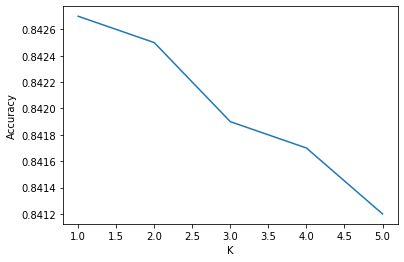

In [19]:
plt.plot(range(1, 6), accuracy)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

## 5.

Report your confusion matrix for the best k. This is a 10x10 matrix whose entry in row r and column c is the percentage of test images from class r that are classified as class c. (Tip: You should be able to achieve at least 70% accuracy on the test set.)

In [20]:
cm = bayes_models[5].get_confusion_matrix(test)

In [21]:
print("Confusion matrix")
title = ''.join("{:8s}".format(str(digit)) for digit in [''] + DIGITS)
print(title)
for i, row in enumerate(cm):
    line = ''.join("{:8s}".format(str(digit)) for digit in [str(i)] + list(row))
    print(line)

Confusion matrix
        0       1       2       3       4       5       6       7       8       9       
0       882     0       3       4       1       51      21      1       17      0       
1       0       1086    6       5       0       9       4       0       25      0       
2       17      14      838     32      23      5       27      16      58      2       
3       4       18      34      839     1       30      7       13      45      19      
4       2       10      4       0       797     1       15      1       11      141     
5       18      13      6       105     25      648     18      8       25      26      
6       18      16      15      1       14      35      852     0       7       0       
7       2       34      17      3       17      0       0       864     25      66      
8       11      29      12      69      15      26      10      6       760     36      
9       13      14      6       8       63      9       0       29      21      846     
